# Blocksim

`tbcontrol.blocksim` is a simple library for simulating the kinds of block diagrams you would encounter in a typical undergraduate control textbook. Let's start with the most basic example of feedback control.

![](../assets/simple_feedback.png)

In [1]:
from tbcontrol import blocksim

Our first job is to define objects representing each of the blocks. A common one is the LTI block

In [2]:
Gp = blocksim.LTI('Gp', 'u', 'y', 10, [100, 1], 50)

In [3]:
Gp

LTI: u →[ Gp ]→ y

We'll use a PI controller

In [4]:
Gc = blocksim.PI('Gc', 'e', 'u', 0.1, 50)

In [5]:
Gc

PI: e →[ Gc ]→ u

Once we have the blocks, we can create a Diagram.

Sums are specified as a dictionary with the keys being the output signal and the values being a tuple containing the input signals. The leading + is compulsory.

The inputs come next and are specified as functions of time. `Blocksim.step()` can be used to build a step function.

In [6]:
diagram = blocksim.Diagram([Gp, Gc], 
                           sums={'e': ('+ysp', '-y')}, 
                           inputs={'ysp': blocksim.step()})

In [7]:
diagram

LTI: u →[ Gp ]→ y
PI: e →[ Gc ]→ u

Blocksim is primarily focused on being able to simulate a diagram. The next step is to create a time vector and do the simulation.

In [8]:
import numpy

The time vector also specifies the step size for integration. Since blocksim uses Euler integration internally you should choose a time step which is at least 10 times smaller than the smallest time constant of all the blocks. The timespan is of course dependent on what you are investigating.

In [9]:
ts = numpy.arange(start=0, stop=1000, step=1)

In [10]:
simulation_results = diagram.simulate(ts, progress=True)

The result of `simulate()` is a dictionary containing the simulation results.

In [11]:
import matplotlib.pyplot as plt

In [12]:
%matplotlib inline

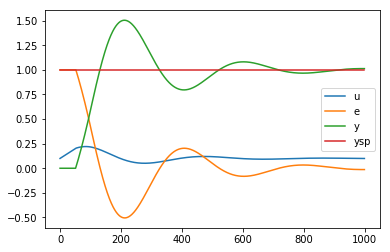

In [13]:
for signal, value in simulation_results.items():
    plt.plot(ts, value, label=signal)
plt.legend()

## Re-using parts of a diagram

Let's compare the output of a PI and a PID controller on this system. We've already got the PI response, which we should store.

In [14]:
y_pi = simulation_results['y']

Let's swap out the PI controller for a PID.

In [15]:
Gc_pid = blocksim.PID('Gc', 'e', 'u', 0.1, 50, 25)

In [16]:
diagram.blocks = [Gp, Gc_pid]

In [17]:
simulation_results = diagram.simulate(ts, progress=True)

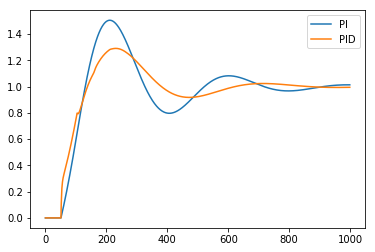

In [18]:
plt.plot(ts, y_pi, label='PI')
plt.plot(ts, simulation_results['y'], label='PID')
plt.legend()

We can see that adding the derivative action has improved control.

# Disturbances

We can simulate a more complicated block diagram with a disturbance.

![](../assets/standard_feedback.png)

In [19]:
Km = blocksim.LTI('Km', 'ysp', 'ytildesp', 1, 1)
Gc = blocksim.PI('Gp', 'e', 'p', Kc=8, tau_i=10)
Gv = blocksim.LTI('Gv', 'p', 'u', 1, 1)
Gp = blocksim.LTI('Gp', 'u', 'yu', [1], [10, 1])
Gd = blocksim.LTI('Gd', 'd', 'yd', [1], [10, 1])
Gm = blocksim.LTI('Gm', 'y', 'ym', [1], [1, 1])

blocks = [Km, Gc, Gv, Gp, Gd, Gm]

In [20]:
sums = {'e': ('+ytildesp', '-ym'),
        'y': ('+yd', '+yu')}

inputs = {'ysp': blocksim.step(),
          'd': blocksim.step(starttime=50)}

In [21]:
diagram = blocksim.Diagram(blocks, sums, inputs)

In [22]:
ts = numpy.arange(start=0, stop=100, step=0.05)

In [23]:
results = diagram.simulate(ts, progress=True)

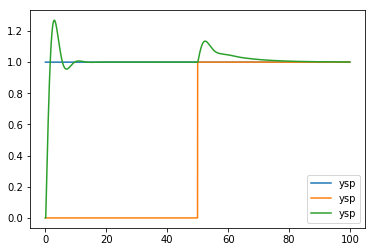

In [24]:
for name in ('ysp', 'd', 'y'):
    plt.plot(ts, results[name], label=signal)
plt.legend()